In [1]:
import numpy as np
import pandas as pd
from cmdstanpy import CmdStanModel
from matplotlib import pyplot as plt

# Load and plot data

In [2]:
df = pd.read_csv("data/data-ss2.txt")
print(len(df))
df.head(5)

44


,X,Y
0,1,18.073
1,2,23.665
2,3,16.410
3,4,14.931
4,5,17.106


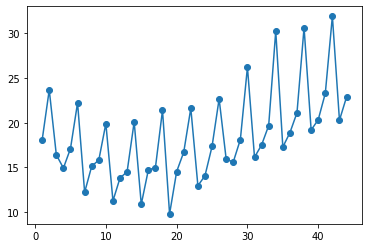

In [3]:
plt.plot(df["X"], df["Y"], "o-")

# Run Stan

In [4]:
model = CmdStanModel(stan_file="model/model-exec-12-2.stan")
print(model)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /workdir/chap12/model/model-exec-12-2


CmdStanModel: name=model-exec-12-2
	 stan_file=/workdir/chap12/model/model-exec-12-2.stan
	 exe_file=/workdir/chap12/model/model-exec-12-2
	 compiler_optons=stanc_options=None, cpp_options=None


In [5]:
T_pred = 32

data = {
    "T": len(df),
    "T_pred": T_pred,
    "Y": df["Y"].values
}

In [12]:
# 収束しないこともあるので、初期値を与えてみる
fit = model.sample(data=data, inits={"mu":df["Y"].values})

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2


In [13]:
summary = fit.summary()
summary[summary["R_hat"] >= 1.1]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,


# Plot result

In [14]:
mu_percentiles = np.percentile(fit.stan_variable("mu_all"), [10.0, 25.0, 50.0, 75.0, 90.0] , axis=0)
season_percentiles = np.percentile(fit.stan_variable("season_all"), [10.0, 25.0, 50.0, 75.0, 90.0] , axis=0)

In [15]:
y_mean_percentiles = np.percentile(
    fit.stan_variable("mu_all") + fit.stan_variable("season_all"), 
    [10.0, 25.0, 50.0, 75.0, 90.0] , 
    axis=0
)

In [16]:
def plot_pred(ax, xx, percentiles):
    ax.fill_between(xx, percentiles[0], percentiles[4], alpha=0.3, color="C1")
    ax.fill_between(xx, percentiles[1], percentiles[3], alpha=0.6, color="C1")
    ax.plot(xx, percentiles[2], color="C1")
    ax.set_xlabel("Time(day)")

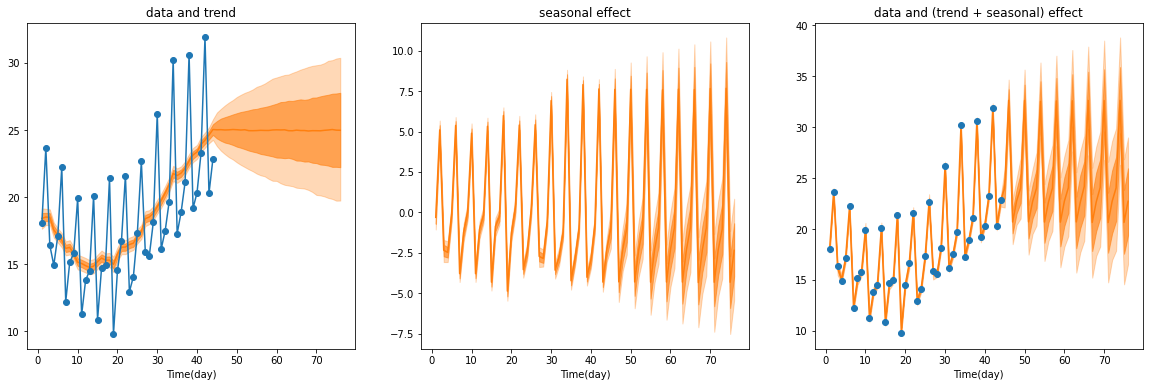

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6), sharex=True, sharey=False)
xx = np.arange(1, len(df)+T_pred+1)

plot_pred(ax=axes[0], xx=xx, percentiles=mu_percentiles)
axes[0].plot(df["X"].values, df["Y"].values, 'o-', color="C0")
axes[0].set_title("data and trend")

plot_pred(ax=axes[1], xx=xx, percentiles=season_percentiles)
axes[1].set_title("seasonal effect")

plot_pred(ax=axes[2], xx=xx, percentiles=y_mean_percentiles)
axes[2].plot(df["X"].values, df["Y"].values, 'o', color="C0")
axes[2].set_title("data and (trend + seasonal) effect")
fig.show()